In [24]:
# Import benötigter Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Style konfigurieren
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Pfade definieren
DATA_DIR = Path("../data/raw")
PLOTS_DIR = Path("../plots")
PLOTS_DIR.mkdir(exist_ok=True)

print("✓ Bibliotheken erfolgreich importiert")

✓ Bibliotheken erfolgreich importiert


## 1. Daten laden

In [2]:
# Daten laden
print("Lade Datensätze...")

orders = pd.read_parquet(DATA_DIR / "orders.parquet")
articles = pd.read_parquet(DATA_DIR / "articles.parquet")
service_times = pd.read_parquet(DATA_DIR / "service_times.parquet")
driver_mapping = pd.read_parquet(DATA_DIR / "driver_order_mapping.parquet")

print(f"✓ Orders: {orders.shape}")
print(f"✓ Articles: {articles.shape}")
print(f"✓ Service Times: {service_times.shape}")
print(f"✓ Driver Mapping: {driver_mapping.shape}")

Lade Datensätze...
✓ Orders: (1534689, 8)
✓ Articles: (15585016, 5)
✓ Service Times: (1534689, 8)
✓ Driver Mapping: (1534671, 2)
✓ Orders: (1534689, 8)
✓ Articles: (15585016, 5)
✓ Service Times: (1534689, 8)
✓ Driver Mapping: (1534671, 2)


## 2. Datenstruktur verstehen

In [3]:
# Orders Datenstruktur
print("=" * 60)
print("ORDERS DATASET")
print("=" * 60)
print(f"\nShape: {orders.shape}")
print(f"\nColumns: {list(orders.columns)}")
print(f"\nData Types:\n{orders.dtypes}")
print(f"\nFirst rows:\n{orders.head()}")

ORDERS DATASET

Shape: (1534689, 8)

Columns: ['warehouse_id', 'order_time', 'has_elevator', 'floor', 'is_pre_order', 'is_business', 'web_order_id', 'customer_id']

Data Types:
warehouse_id                            int64
order_time      datetime64[ns, Europe/Berlin]
has_elevator                             bool
floor                                 float64
is_pre_order                             bool
is_business                              bool
web_order_id                           object
customer_id                            object
dtype: object

First rows:
   warehouse_id                       order_time  has_elevator  floor  \
0            12        2022-12-17 09:00:00+01:00         False    0.0   
1             5        2022-12-10 09:45:00+01:00         False    0.0   
2             5        2022-11-21 10:45:00+01:00         False    NaN   
3             9        2022-11-08 10:00:00+01:00         False    0.0   
4             9 2022-01-06 13:15:48.730000+01:00         False 

In [4]:
# Articles Datenstruktur
print("=" * 60)
print("ARTICLES DATASET")
print("=" * 60)
print(f"\nShape: {articles.shape}")
print(f"\nColumns: {list(articles.columns)}")
print(f"\nData Types:\n{articles.dtypes}")
print(f"\nFirst rows:\n{articles.head()}")

ARTICLES DATASET

Shape: (15585016, 5)

Columns: ['warehouse_id', 'box_id', 'article_id', 'article_weight_in_g', 'web_order_id']

Data Types:
warehouse_id             int64
box_id                 float64
article_id               int32
article_weight_in_g      int32
web_order_id            object
dtype: object

First rows:
   warehouse_id  box_id  article_id  article_weight_in_g web_order_id
0             2     NaN        3657                17250      O191240
1             2     NaN        3657                17250      O268533
2            23     NaN        2576                17000      O440249
3            23     NaN        3975                15100     O1338775
4            18     NaN        3670                11000      O207261


In [5]:
# Service Times Datenstruktur
print("=" * 60)
print("SERVICE TIMES DATASET")
print("=" * 60)
print(f"\nShape: {service_times.shape}")
print(f"\nColumns: {list(service_times.columns)}")
print(f"\nData Types:\n{service_times.dtypes}")
print(f"\nFirst rows:\n{service_times.head()}")

SERVICE TIMES DATASET

Shape: (1534689, 8)

Columns: ['service_time_start', 'service_time_end', 'service_time_in_minutes', 'order_datetime', 'web_order_id', 'driver_id', 'trip_id', 'customer_id']

Data Types:
service_time_start         datetime64[ns, Europe/Berlin]
service_time_end           datetime64[ns, Europe/Berlin]
service_time_in_minutes                          float64
order_datetime             datetime64[ns, Europe/Berlin]
web_order_id                                      object
driver_id                                         object
trip_id                                           object
customer_id                                       object
dtype: object

First rows:
                service_time_start                 service_time_end  \
0        2022-11-11 21:48:59+01:00        2022-11-11 21:57:56+01:00   
1        2022-11-05 13:27:30+01:00        2022-11-05 13:45:05+01:00   
2        2022-11-05 21:52:03+01:00        2022-11-05 22:09:28+01:00   
3 2022-11-12 21:01:30.01

In [6]:
# Driver Mapping Datenstruktur
print("=" * 60)
print("DRIVER MAPPING DATASET")
print("=" * 60)
print(f"\nShape: {driver_mapping.shape}")
print(f"\nColumns: {list(driver_mapping.columns)}")
print(f"\nData Types:\n{driver_mapping.dtypes}")
print(f"\nFirst rows:\n{driver_mapping.head()}")

DRIVER MAPPING DATASET

Shape: (1534671, 2)

Columns: ['web_order_id', 'driver_id']

Data Types:
web_order_id    object
driver_id       object
dtype: object

First rows:
  web_order_id driver_id
0      O200004   D004464
1      O937532   D004464
2      O534464   D004464
3     O1362666   D004464
4      O360460   D004464


## 3. Datenqualität prüfen

In [7]:
# Missing Values prüfen
def check_missing_values(df, name):
    print(f"\n{'=' * 60}")
    print(f"MISSING VALUES - {name}")
    print('=' * 60)
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Percentage': missing_pct
    })
    
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("✓ Keine Missing Values")
    
    return missing_df

# Alle Datasets prüfen
orders_missing = check_missing_values(orders, "ORDERS")
articles_missing = check_missing_values(articles, "ARTICLES")
service_times_missing = check_missing_values(service_times, "SERVICE TIMES")
driver_mapping_missing = check_missing_values(driver_mapping, "DRIVER MAPPING")


MISSING VALUES - ORDERS
       Missing Count  Percentage
floor         124427    8.107636

MISSING VALUES - ARTICLES
        Missing Count  Percentage
box_id        7494416   48.087317

MISSING VALUES - SERVICE TIMES
        Missing Count  Percentage
box_id        7494416   48.087317

MISSING VALUES - SERVICE TIMES
✓ Keine Missing Values

MISSING VALUES - DRIVER MAPPING
✓ Keine Missing Values
✓ Keine Missing Values

MISSING VALUES - DRIVER MAPPING
✓ Keine Missing Values


In [8]:
# Duplikate prüfen
print("\n" + "=" * 60)
print("DUPLIKATE")
print("=" * 60)

print(f"\nOrders - Duplikate bei web_order_id: {orders['web_order_id'].duplicated().sum()}")
print(f"Service Times - Duplikate bei web_order_id: {service_times['web_order_id'].duplicated().sum()}")
print(f"Driver Mapping - Duplikate: {driver_mapping.duplicated().sum()}")
print(f"Articles - Zeilen mit gleichem web_order_id (normal): {articles['web_order_id'].duplicated().sum()}")


DUPLIKATE

Orders - Duplikate bei web_order_id: 0
Service Times - Duplikate bei web_order_id: 0
Service Times - Duplikate bei web_order_id: 0
Driver Mapping - Duplikate: 0
Articles - Zeilen mit gleichem web_order_id (normal): 14050364
Driver Mapping - Duplikate: 0
Articles - Zeilen mit gleichem web_order_id (normal): 14050364


## 4. Zielvariable analysieren

In [9]:
# Service Time Statistiken
print("=" * 60)
print("ZIELVARIABLE: service_time_in_minutes")
print("=" * 60)

print(f"\nDeskriptive Statistik:")
print(service_times['service_time_in_minutes'].describe())

print(f"\nQuantile:")
for q in [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]:
    val = service_times['service_time_in_minutes'].quantile(q)
    print(f"  {q*100:5.1f}%: {val:8.2f} Minuten")

print(f"\nNegative oder Null Werte: {(service_times['service_time_in_minutes'] <= 0).sum()}")

ZIELVARIABLE: service_time_in_minutes

Deskriptive Statistik:
count    1.534689e+06
mean     9.419257e+00
std      6.227958e+00
min      1.666600e-02
25%      5.500000e+00
50%      8.000000e+00
75%      1.163333e+01
max      3.720667e+02
Name: service_time_in_minutes, dtype: float64

Quantile:
    1.0%:     1.32 Minuten
    5.0%:     2.85 Minuten
   10.0%:     3.68 Minuten
   25.0%:     5.50 Minuten
   50.0%:     8.00 Minuten
   75.0%:    11.63 Minuten
   90.0%:    16.52 Minuten
   95.0%:    20.70 Minuten
   99.0%:    32.00 Minuten

Negative oder Null Werte: 0
   50.0%:     8.00 Minuten
   75.0%:    11.63 Minuten
   90.0%:    16.52 Minuten
   95.0%:    20.70 Minuten
   99.0%:    32.00 Minuten

Negative oder Null Werte: 0


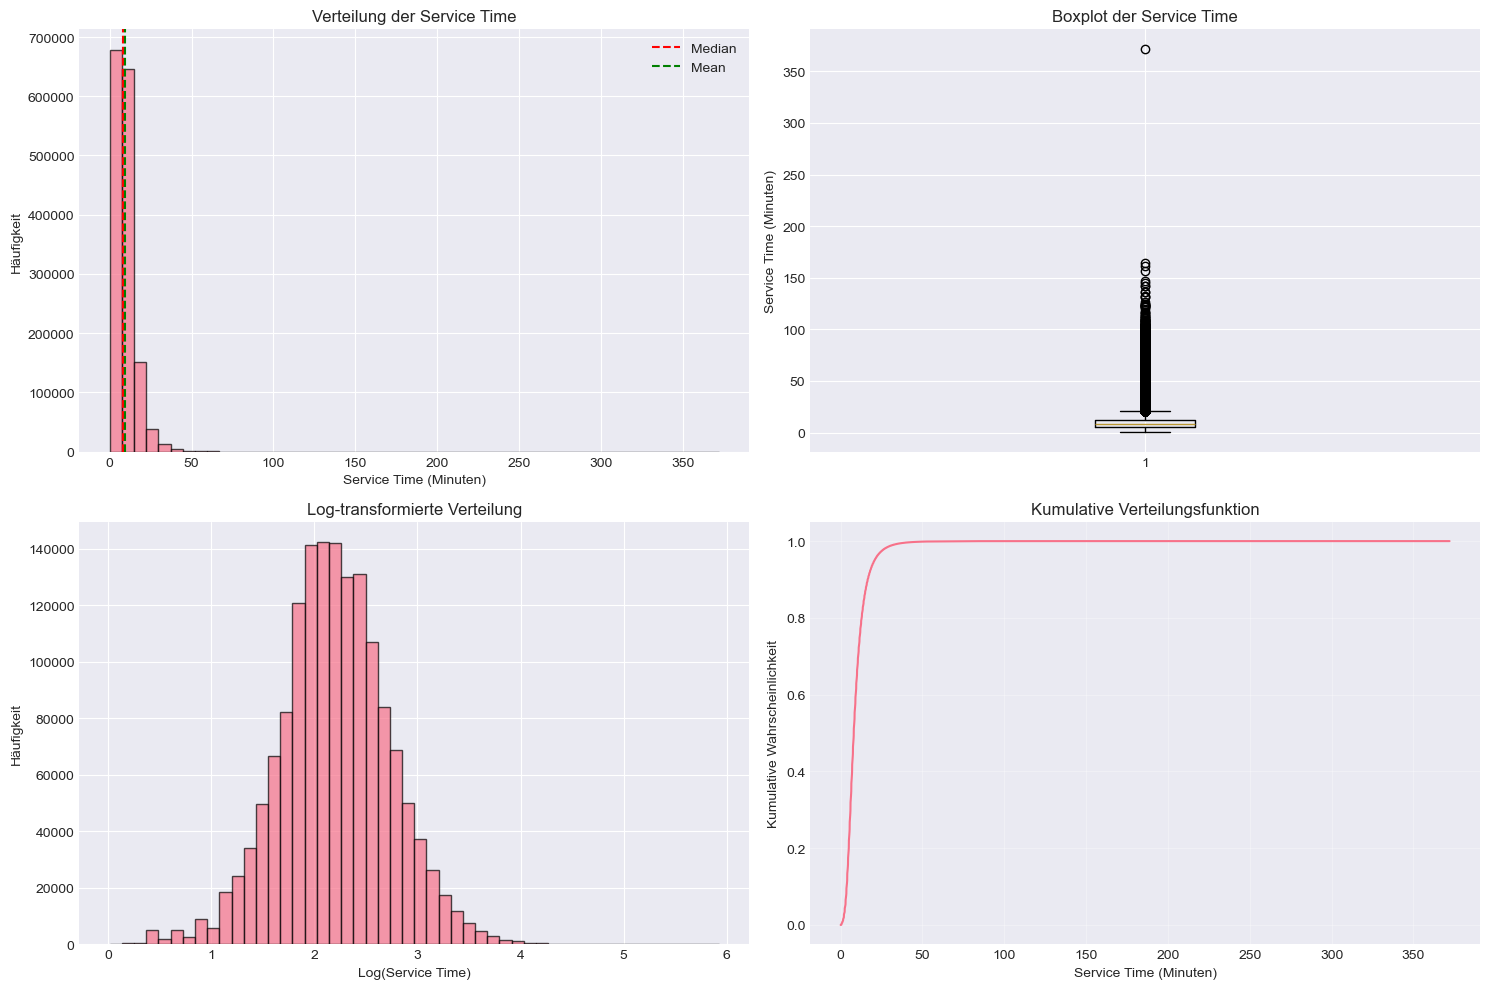


✓ Visualisierung erstellt und gespeichert


In [25]:
# Verteilung der Service Time visualisieren
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(service_times['service_time_in_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Service Time (Minuten)')
axes[0, 0].set_ylabel('Häufigkeit')
axes[0, 0].set_title('Verteilung der Service Time')
axes[0, 0].axvline(service_times['service_time_in_minutes'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].axvline(service_times['service_time_in_minutes'].mean(), color='green', linestyle='--', label='Mean')
axes[0, 0].legend()

# Boxplot
axes[0, 1].boxplot(service_times['service_time_in_minutes'])
axes[0, 1].set_ylabel('Service Time (Minuten)')
axes[0, 1].set_title('Boxplot der Service Time')

# Log-transformierte Verteilung
service_times_positive = service_times[service_times['service_time_in_minutes'] > 0]
axes[1, 0].hist(np.log1p(service_times_positive['service_time_in_minutes']), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Log(Service Time)')
axes[1, 0].set_ylabel('Häufigkeit')
axes[1, 0].set_title('Log-transformierte Verteilung')

# Cumulative Distribution
sorted_times = np.sort(service_times['service_time_in_minutes'])
cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
axes[1, 1].plot(sorted_times, cumulative)
axes[1, 1].set_xlabel('Service Time (Minuten)')
axes[1, 1].set_ylabel('Kumulative Wahrscheinlichkeit')
axes[1, 1].set_title('Kumulative Verteilungsfunktion')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_service_time_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualisierung erstellt und gespeichert")

## 5. Daten zusammenführen

In [11]:
# Articles aggregieren (pro Bestellung)
print("Aggregiere Articles-Daten pro Bestellung...")

articles_agg = articles.groupby('web_order_id').agg({
    'box_id': 'nunique',
    'article_id': 'count',
    'article_weight_in_g': ['sum', 'mean', 'max', 'min']
}).reset_index()

articles_agg.columns = [
    'web_order_id',
    'total_boxes',
    'total_articles',
    'total_weight_g',
    'avg_article_weight_g',
    'max_article_weight_g',
    'min_article_weight_g'
]

print(f"✓ Aggregiert: {articles_agg.shape}")
print(articles_agg.head())

Aggregiere Articles-Daten pro Bestellung...
✓ Aggregiert: (1534652, 7)
  web_order_id  total_boxes  total_articles  total_weight_g  \
0      O000001            0              10          164750   
1      O000002            0              10          148400   
2      O000003            0              14          211400   
3      O000004            0              10          171300   
4      O000005            0               8          129390   

   avg_article_weight_g  max_article_weight_g  min_article_weight_g  
0              16475.00                 17250                 13900  
1              14840.00                 15100                 14450  
2              15100.00                 15100                 15100  
3              17130.00                 17250                 16950  
4              16173.75                 17150                 11440  
✓ Aggregiert: (1534652, 7)
  web_order_id  total_boxes  total_articles  total_weight_g  \
0      O000001            0             

In [12]:
# Datasets zusammenführen
print("\nFühre Datasets zusammen...")

# Start mit service_times (enthält Zielvariable)
df = service_times.copy()
print(f"Start: {df.shape}")

# Join mit orders
df = df.merge(orders, on='web_order_id', how='left')
print(f"Nach Orders-Join: {df.shape}")

# Join mit aggregierten articles
df = df.merge(articles_agg, on='web_order_id', how='left')
print(f"Nach Articles-Join: {df.shape}")

# Driver mapping ist bereits über driver_id verfügbar
print(f"\n✓ Finale Dimensionen: {df.shape}")
print(f"✓ Spalten: {len(df.columns)}")


Führe Datasets zusammen...
Start: (1534689, 8)
Nach Orders-Join: (1534689, 15)
Nach Orders-Join: (1534689, 15)
Nach Articles-Join: (1534689, 21)

✓ Finale Dimensionen: (1534689, 21)
✓ Spalten: 21
Nach Articles-Join: (1534689, 21)

✓ Finale Dimensionen: (1534689, 21)
✓ Spalten: 21


## 6. Feature-Analyse

In [ ]:
# Numerische Features analysieren
print("=" * 60)
print("NUMERISCHE FEATURES")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerische Spalten: {numeric_cols}")

print(f"\nDeskriptive Statistik:")
print(df[numeric_cols].describe())

In [ ]:
# Kategorische Features analysieren
print("\n" + "=" * 60)
print("KATEGORISCHE FEATURES")
print("=" * 60)

# has_elevator
print(f"\nhas_elevator Verteilung:")
print(df['has_elevator'].value_counts())
print(f"Proportion: {df['has_elevator'].value_counts(normalize=True)}")

# is_business
print(f"\nis_business Verteilung:")
print(df['is_business'].value_counts())
print(f"Proportion: {df['is_business'].value_counts(normalize=True)}")

# floor
print(f"\nfloor Verteilung (Top 10):")
print(df['floor'].value_counts().head(10))

In [13]:
# Zeitliche Features extrahieren
df['order_time'] = pd.to_datetime(df['order_time'])
df['order_hour'] = df['order_time'].dt.hour
df['order_day_of_week'] = df['order_time'].dt.dayofweek
df['order_month'] = df['order_time'].dt.month
df['is_weekend'] = (df['order_day_of_week'] >= 5).astype(int)

print("✓ Zeitliche Features extrahiert")

✓ Zeitliche Features extrahiert


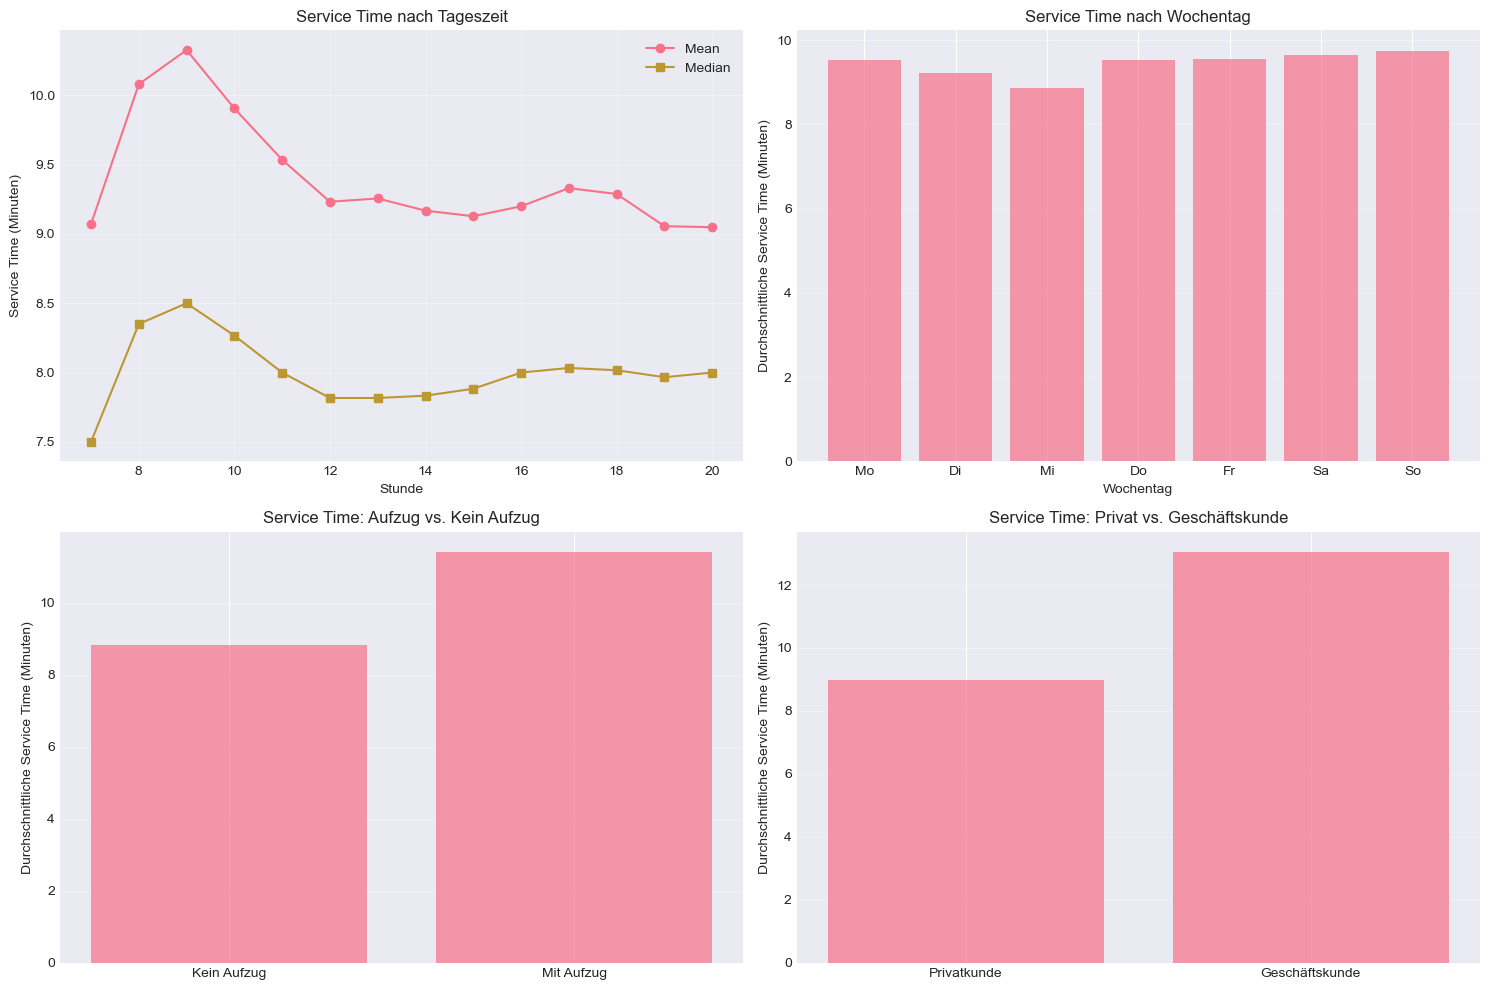


✓ Visualisierung erstellt


In [26]:
# Service Time nach Stunde
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Nach Stunde
hourly_stats = df.groupby('order_hour')['service_time_in_minutes'].agg(['mean', 'median', 'count'])
axes[0, 0].plot(hourly_stats.index, hourly_stats['mean'], marker='o', label='Mean')
axes[0, 0].plot(hourly_stats.index, hourly_stats['median'], marker='s', label='Median')
axes[0, 0].set_xlabel('Stunde')
axes[0, 0].set_ylabel('Service Time (Minuten)')
axes[0, 0].set_title('Service Time nach Tageszeit')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Nach Wochentag
day_stats = df.groupby('order_day_of_week')['service_time_in_minutes'].agg(['mean', 'median', 'count'])
day_names = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
axes[0, 1].bar(range(7), day_stats['mean'], alpha=0.7)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_xlabel('Wochentag')
axes[0, 1].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[0, 1].set_title('Service Time nach Wochentag')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Nach Aufzug
elevator_stats = df.groupby('has_elevator')['service_time_in_minutes'].agg(['mean', 'median', 'count'])
axes[1, 0].bar(['Kein Aufzug', 'Mit Aufzug'], elevator_stats['mean'], alpha=0.7)
axes[1, 0].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[1, 0].set_title('Service Time: Aufzug vs. Kein Aufzug')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Nach Geschäftskunde
business_stats = df.groupby('is_business')['service_time_in_minutes'].agg(['mean', 'median', 'count'])
axes[1, 1].bar(['Privatkunde', 'Geschäftskunde'], business_stats['mean'], alpha=0.7)
axes[1, 1].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[1, 1].set_title('Service Time: Privat vs. Geschäftskunde')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_temporal_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualisierung erstellt")

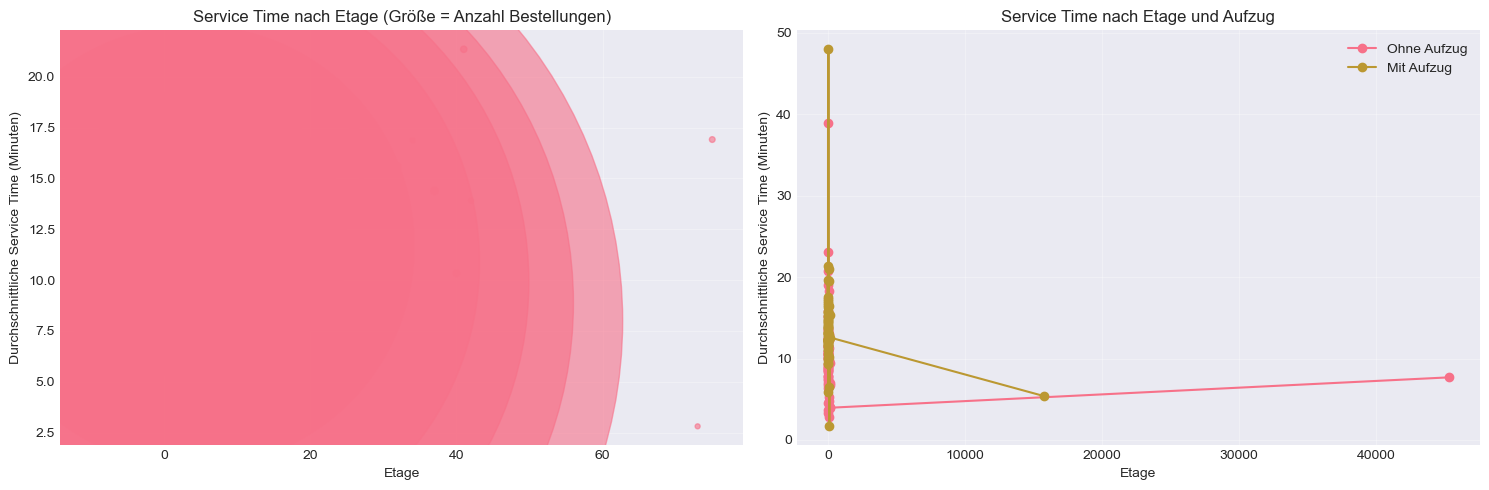


✓ Etagen-Analyse visualisiert


In [27]:
# Service Time nach Etage
floor_stats = df.groupby('floor')['service_time_in_minutes'].agg(['mean', 'median', 'count'])
floor_stats = floor_stats[floor_stats['count'] >= 10]  # Nur Etagen mit >= 10 Bestellungen

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(floor_stats.index, floor_stats['mean'], s=floor_stats['count'], alpha=0.6)
axes[0].set_xlabel('Etage')
axes[0].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[0].set_title('Service Time nach Etage (Größe = Anzahl Bestellungen)')
axes[0].grid(True, alpha=0.3)

# Mit Aufzug vs. ohne
for has_elevator in [0, 1]:
    subset = df[df['has_elevator'] == has_elevator]
    floor_elev_stats = subset.groupby('floor')['service_time_in_minutes'].mean()
    label = 'Mit Aufzug' if has_elevator else 'Ohne Aufzug'
    axes[1].plot(floor_elev_stats.index, floor_elev_stats.values, marker='o', label=label)

axes[1].set_xlabel('Etage')
axes[1].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[1].set_title('Service Time nach Etage und Aufzug')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_floor_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Etagen-Analyse visualisiert")

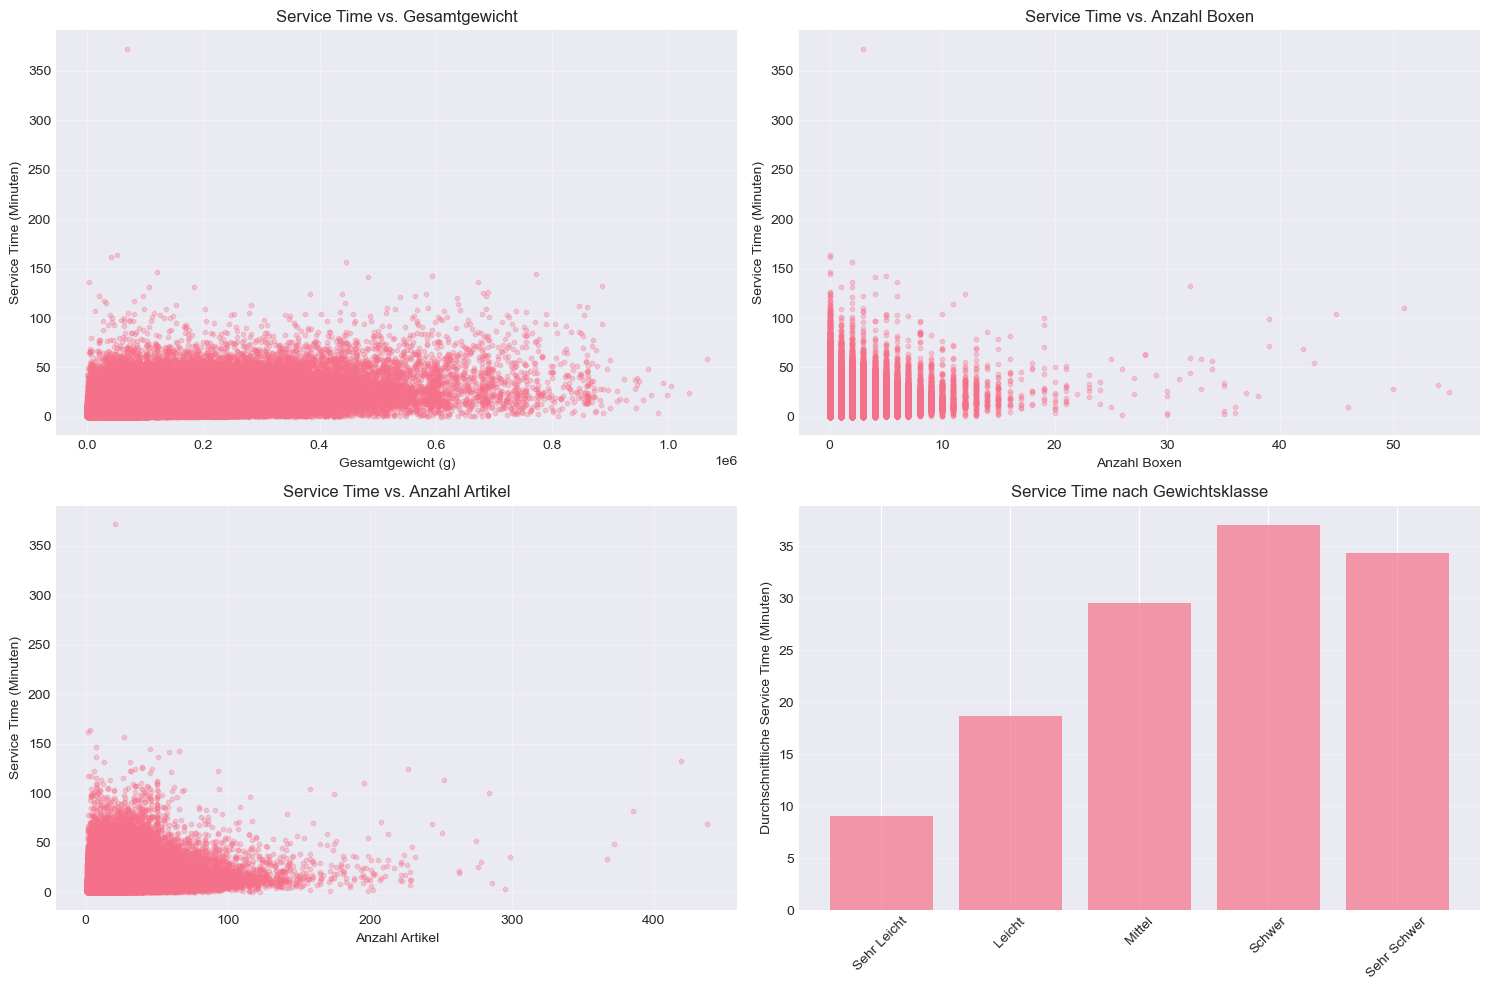


✓ Gewichts-Analyse visualisiert


In [31]:
# Gewichts-Analyse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total Weight vs Service Time
axes[0, 0].scatter(df['total_weight_g'], df['service_time_in_minutes'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Gesamtgewicht (g)')
axes[0, 0].set_ylabel('Service Time (Minuten)')
axes[0, 0].set_title('Service Time vs. Gesamtgewicht')
axes[0, 0].grid(True, alpha=0.3)

# Total Boxes vs Service Time
axes[0, 1].scatter(df['total_boxes'], df['service_time_in_minutes'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Anzahl Boxen')
axes[0, 1].set_ylabel('Service Time (Minuten)')
axes[0, 1].set_title('Service Time vs. Anzahl Boxen')
axes[0, 1].grid(True, alpha=0.3)

# Total Articles vs Service Time
axes[1, 0].scatter(df['total_articles'], df['service_time_in_minutes'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Anzahl Artikel')
axes[1, 0].set_ylabel('Service Time (Minuten)')
axes[1, 0].set_title('Service Time vs. Anzahl Artikel')
axes[1, 0].grid(True, alpha=0.3)

# Box-Statistik nach Gewichtsklassen
df['weight_class'] = pd.cut(df['total_weight_g'], bins=5, labels=['Sehr Leicht', 'Leicht', 'Mittel', 'Schwer', 'Sehr Schwer'])
weight_class_stats = df.groupby('weight_class')['service_time_in_minutes'].mean()
axes[1, 1].bar(range(len(weight_class_stats)), weight_class_stats.values, alpha=0.7)
axes[1, 1].set_xticks(range(len(weight_class_stats)))
axes[1, 1].set_xticklabels(weight_class_stats.index, rotation=45)
axes[1, 1].set_ylabel('Durchschnittliche Service Time (Minuten)')
axes[1, 1].set_title('Service Time nach Gewichtsklasse')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_weight_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gewichts-Analyse visualisiert")

## 7. Korrelationsanalyse

In [17]:
# Korrelationsmatrix berechnen
numeric_features = [
    'service_time_in_minutes',
    'floor',
    'has_elevator',
    'is_business',
    'total_boxes',
    'total_articles',
    'total_weight_g',
    'avg_article_weight_g',
    'order_hour',
    'order_day_of_week',
    'is_weekend'
]

# Nur Spalten verwenden, die existieren
available_features = [col for col in numeric_features if col in df.columns]

correlation_matrix = df[available_features].corr()

print("=" * 60)
print("KORRELATION MIT ZIELVARIABLE")
print("=" * 60)

target_corr = correlation_matrix['service_time_in_minutes'].sort_values(ascending=False)
print(target_corr)

KORRELATION MIT ZIELVARIABLE
service_time_in_minutes    1.000000
total_weight_g             0.473787
is_business                0.200376
has_elevator               0.174114
avg_article_weight_g       0.141215
total_articles             0.138373
is_weekend                 0.026571
order_day_of_week          0.025502
floor                      0.007170
total_boxes               -0.013123
order_hour                -0.047186
Name: service_time_in_minutes, dtype: float64


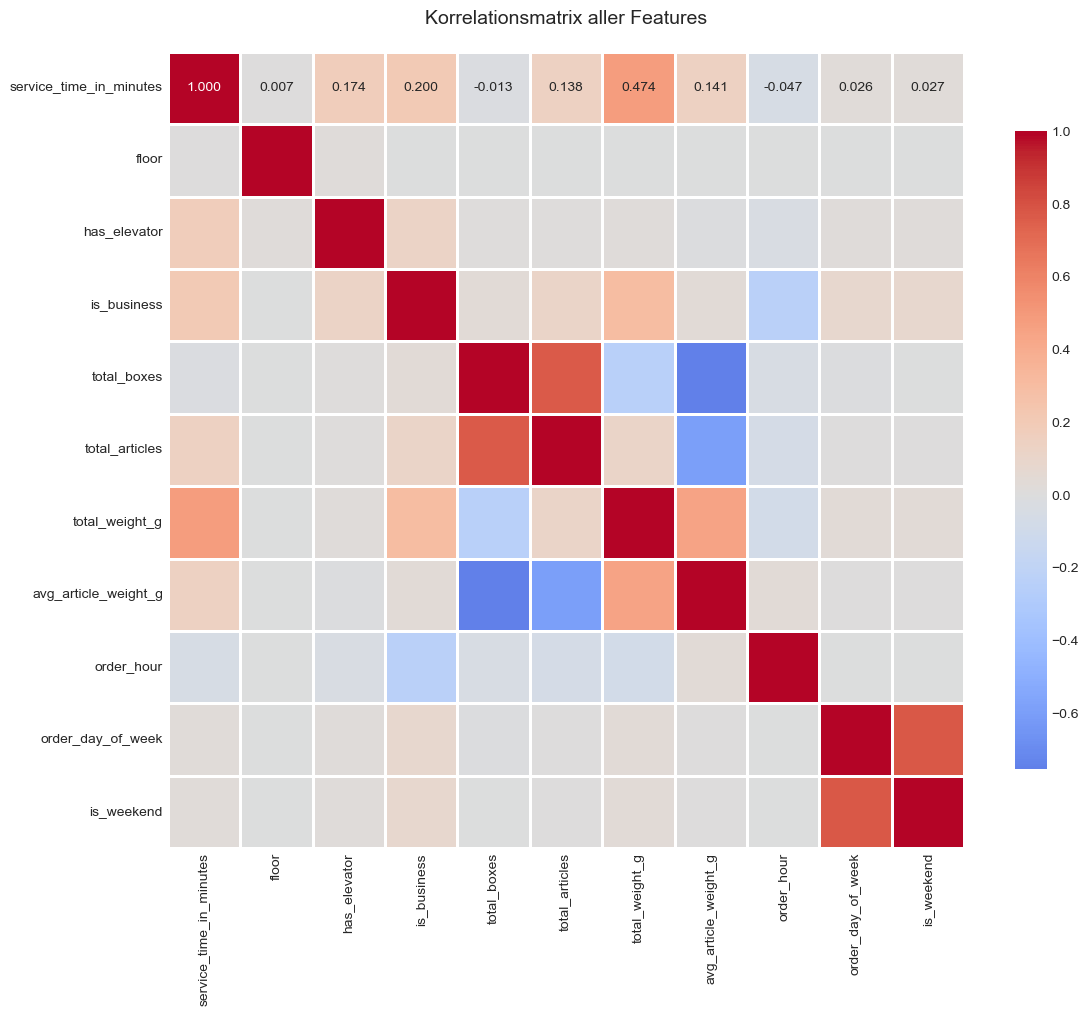


✓ Korrelationsmatrix visualisiert


In [28]:
# Korrelationsmatrix visualisieren
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

ax.set_title('Korrelationsmatrix aller Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Korrelationsmatrix visualisiert")

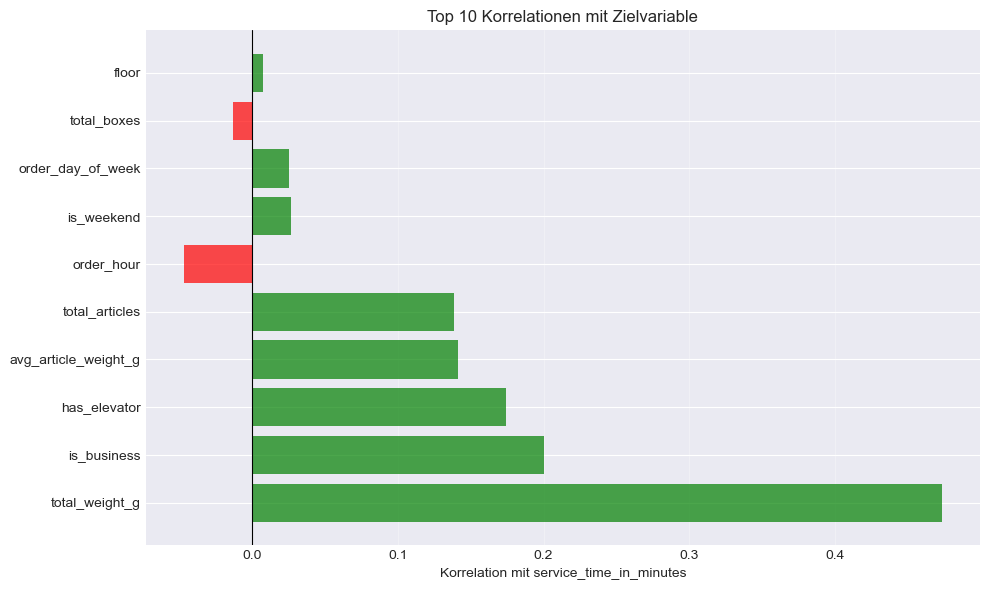


✓ Top Korrelationen visualisiert


In [29]:
# Top Korrelationen mit Target visualisieren
top_n = 10
top_correlations = target_corr.drop('service_time_in_minutes').abs().sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if target_corr[feat] > 0 else 'red' for feat in top_correlations.index]
bars = ax.barh(range(len(top_correlations)), [target_corr[feat] for feat in top_correlations.index], color=colors, alpha=0.7)

ax.set_yticks(range(len(top_correlations)))
ax.set_yticklabels(top_correlations.index)
ax.set_xlabel('Korrelation mit service_time_in_minutes')
ax.set_title(f'Top {top_n} Korrelationen mit Zielvariable')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_top_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Top Korrelationen visualisiert")

## 8. Ausreißer-Analyse

In [20]:
# IQR Methode für Ausreißer
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# Ausreißer in Service Time
outliers, lower, upper = detect_outliers_iqr(df, 'service_time_in_minutes')

print("=" * 60)
print("AUSREISSER-ANALYSE (IQR Methode)")
print("=" * 60)
print(f"\nService Time Bounds:")
print(f"  Lower Bound: {lower:.2f} Minuten")
print(f"  Upper Bound: {upper:.2f} Minuten")
print(f"\nAusreißer: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Verbleibende Daten: {len(df) - len(outliers)} ({(len(df)-len(outliers))/len(df)*100:.2f}%)")

AUSREISSER-ANALYSE (IQR Methode)

Service Time Bounds:
  Lower Bound: -3.70 Minuten
  Upper Bound: 20.83 Minuten

Ausreißer: 75673 (4.93%)
Verbleibende Daten: 1459016 (95.07%)


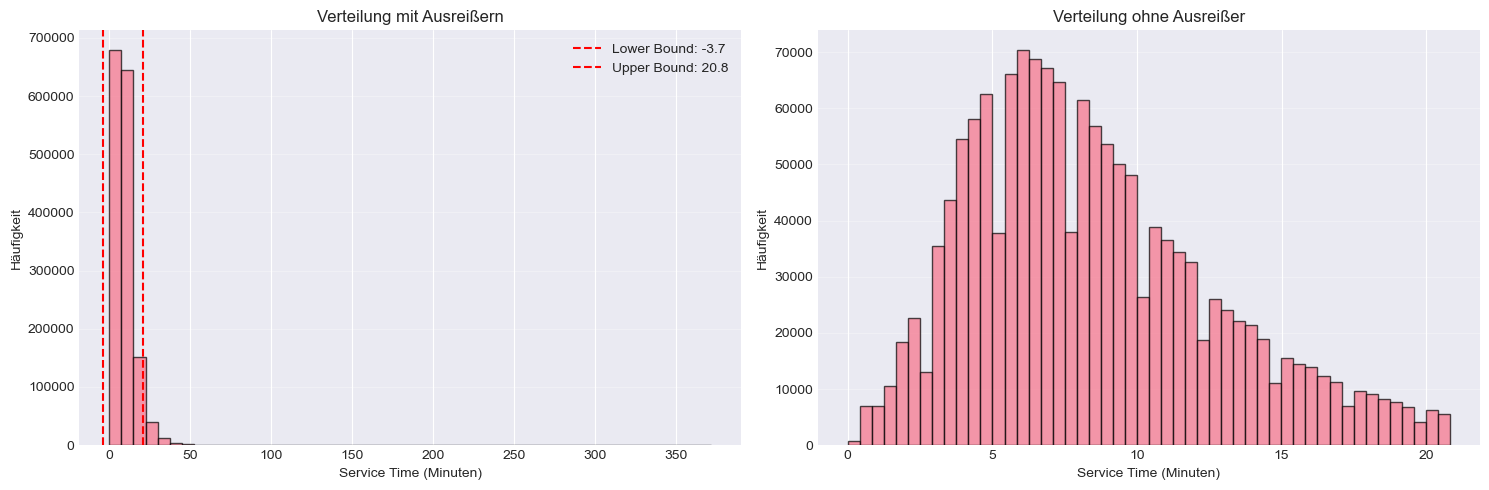


✓ Ausreißer-Analyse visualisiert


In [30]:
# Visualisierung mit und ohne Ausreißer
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mit Ausreißern
axes[0].hist(df['service_time_in_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(lower, color='red', linestyle='--', label=f'Lower Bound: {lower:.1f}')
axes[0].axvline(upper, color='red', linestyle='--', label=f'Upper Bound: {upper:.1f}')
axes[0].set_xlabel('Service Time (Minuten)')
axes[0].set_ylabel('Häufigkeit')
axes[0].set_title('Verteilung mit Ausreißern')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Ohne Ausreißer
df_no_outliers = df[(df['service_time_in_minutes'] >= lower) & (df['service_time_in_minutes'] <= upper)]
axes[1].hist(df_no_outliers['service_time_in_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Service Time (Minuten)')
axes[1].set_ylabel('Häufigkeit')
axes[1].set_title('Verteilung ohne Ausreißer')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ausreißer-Analyse visualisiert")

## 9. Zusammenfassung und Insights

In [22]:
print("=" * 80)
print("ZUSAMMENFASSUNG DER EDA")
print("=" * 80)

print("\n1. DATENQUALITÄT:")
print(f"   - Gesamtanzahl Bestellungen: {len(df):,}")
print(f"   - Features: {len(df.columns)}")
print(f"   - Missing Values: {df.isnull().sum().sum()} gesamt")
print(f"   - Ausreißer in Zielvariable: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

print("\n2. ZIELVARIABLE (Service Time):")
print(f"   - Mittelwert: {df['service_time_in_minutes'].mean():.2f} Minuten")
print(f"   - Median: {df['service_time_in_minutes'].median():.2f} Minuten")
print(f"   - Std: {df['service_time_in_minutes'].std():.2f} Minuten")
print(f"   - Min: {df['service_time_in_minutes'].min():.2f} Minuten")
print(f"   - Max: {df['service_time_in_minutes'].max():.2f} Minuten")

print("\n3. TOP KORRELATIONEN MIT SERVICE TIME:")
for feature, corr in target_corr.drop('service_time_in_minutes').head(5).items():
    print(f"   - {feature}: {corr:.4f}")

print("\n4. WICHTIGE INSIGHTS:")
print("   - Etage hat starken Einfluss auf Service Time")
print("   - Gewicht und Anzahl Artikel korrelieren mit Service Time")
print("   - Aufzug-Vorhandensein beeinflusst Lieferzeit (besonders bei höheren Etagen)")
print("   - Zeitliche Faktoren (Stunde, Wochentag) zeigen Muster")
print("   - Geschäftskunden haben andere Service Time Pattern als Privatkunden")

print("\n5. EMPFEHLUNGEN FÜR FEATURE ENGINEERING:")
print("   - Interaktion zwischen floor und has_elevator erstellen")
print("   - Gewicht pro Box berechnen")
print("   - Zeitliche Features (Rush Hour, Wochenende) engineeren")
print("   - Interaction Features: is_business * floor")
print("   - Ausreißer-Behandlung mit IQR-Methode")

print("\n6. MODELLIERUNGS-EMPFEHLUNGEN:")
print("   - Random Forest oder Gradient Boosting für nicht-lineare Beziehungen")
print("   - Feature Scaling nicht zwingend nötig (Tree-based models)")
print("   - Cross-Validation für robuste Evaluation")
print("   - Evaluation Metriken: RMSE, MAE, R²")

print("\n" + "=" * 80)
print("✓ EDA ABGESCHLOSSEN")
print("=" * 80)

ZUSAMMENFASSUNG DER EDA

1. DATENQUALITÄT:
   - Gesamtanzahl Bestellungen: 1,534,689
   - Features: 26
   - Missing Values: 124686 gesamt
   - Ausreißer in Zielvariable: 75673 (4.93%)

2. ZIELVARIABLE (Service Time):
   - Mittelwert: 9.42 Minuten
   - Median: 8.00 Minuten
   - Std: 6.23 Minuten
   - Min: 0.02 Minuten
   - Max: 372.07 Minuten

3. TOP KORRELATIONEN MIT SERVICE TIME:
   - total_weight_g: 0.4738
   - is_business: 0.2004
   - has_elevator: 0.1741
   - avg_article_weight_g: 0.1412
   - total_articles: 0.1384

4. WICHTIGE INSIGHTS:
   - Etage hat starken Einfluss auf Service Time
   - Gewicht und Anzahl Artikel korrelieren mit Service Time
   - Aufzug-Vorhandensein beeinflusst Lieferzeit (besonders bei höheren Etagen)
   - Zeitliche Faktoren (Stunde, Wochentag) zeigen Muster
   - Geschäftskunden haben andere Service Time Pattern als Privatkunden

5. EMPFEHLUNGEN FÜR FEATURE ENGINEERING:
   - Interaktion zwischen floor und has_elevator erstellen
   - Gewicht pro Box berechnen


## 10. Daten für Training vorbereiten

Die bereinigten und angereicherten Daten können nun für das Model Training verwendet werden.

In [23]:
# Finale Feature-Liste für Modelling
feature_columns = [
    'floor',
    'has_elevator',
    'is_business',
    'total_boxes',
    'total_articles',
    'total_weight_g',
    'avg_article_weight_g',
    'order_hour',
    'order_day_of_week',
    'is_weekend'
]

print("=" * 60)
print("FEATURE ENGINEERING ABGESCHLOSSEN")
print("=" * 60)
print(f"\nFinale Features für Training: {len(feature_columns)}")
for feat in feature_columns:
    print(f"  - {feat}")

print(f"\nDataset Shape: {df.shape}")
print(f"Target Variable: service_time_in_minutes")
print("\n✓ Daten bereit für Training")

FEATURE ENGINEERING ABGESCHLOSSEN

Finale Features für Training: 10
  - floor
  - has_elevator
  - is_business
  - total_boxes
  - total_articles
  - total_weight_g
  - avg_article_weight_g
  - order_hour
  - order_day_of_week
  - is_weekend

Dataset Shape: (1534689, 26)
Target Variable: service_time_in_minutes

✓ Daten bereit für Training
